# 📊 Factor Importance & Visualization Analysis - GRU Model

## Comprehensive Feature Importance Analysis for Depression Prediction

**Objective:** Identify and visualize the most influential variables for the top-performing GRU model

**Key Analysis Components:**
- 🎯 SHAP Analysis (Global & Local Explanations)
- 🔄 Permutation Importance Analysis
- 📈 Feature Correlation & Interaction Analysis
- 🎨 Interactive Visualizations
- 🏥 Clinical Variable Ranking

---
**Model Performance (Top Ranked):**
- MAE: 4.533 ± 0.712
- RMSE: 6.174 ± 0.702
- R²: 0.233 ± 0.200
---

In [1]:
# 📚 Import Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Machine Learning & Model Interpretation
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# SHAP
import shap 

# File handling
import json
import pickle
from pathlib import Path
from datetime import datetime

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("🚀 All libraries imported successfully!")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
# print("⚠️ Note: Using permutation importance instead of SHAP due to numba/llvmlite compatibility issues")

🚀 All libraries imported successfully!
📅 Analysis Date: 2025-09-30 21:56:20


In [2]:
# 📂 Load Dataset and Configuration
BASE_PATH = Path(r'c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN')
DATA_PATH = BASE_PATH / 'Track1_Data' / 'processed'
RESULTS_PATH = BASE_PATH / 'Results'

# Load feature metadata
with open(DATA_PATH / 'feature_metadata.json', 'r') as f:
    feature_metadata = json.load(f)

print("📊 Dataset Overview:")
print(f"   Total Features: {feature_metadata['total_features']}")
print(f"   Dataset Shape: {feature_metadata['dataset_shape']}")
print(f"   Target Variables: {feature_metadata['target_columns']}")
print(f"   Validation Score: {feature_metadata['validation_results']['overall_score']}/100")

# Load processed training data
try:
    train_data = pd.read_excel(DATA_PATH / 'train_engineered_features.xlsx')
    test_data = pd.read_excel(DATA_PATH / 'test_split.xlsx')
    print(f"\n✅ Data loaded successfully!")
    print(f"   Training samples: {len(train_data)}")
    print(f"   Test samples: {len(test_data)}")
except Exception as e:
    print(f"❌ Error loading data: {e}")

# Display feature categories
feature_cols = feature_metadata['feature_columns']
target_cols = feature_metadata['target_columns']

print(f"\n🎯 Target Variables:")
for target in target_cols:
    print(f"   • {target}")

print(f"\n🔍 Feature Categories Detected:")
demographic_features = [f for f in feature_cols if any(term in f.lower() for term in ['age', 'gender'])]
clinical_features = [f for f in feature_cols if any(term in f.lower() for term in ['bdi', 'depression', 'severity'])]
condition_features = [f for f in feature_cols if 'condition' in f.lower()]
therapy_features = [f for f in feature_cols if any(term in f.lower() for term in ['therapy', 'completion', 'session'])]
hospital_features = [f for f in feature_cols if 'hospital' in f.lower()]

print(f"   📈 Demographic: {len(demographic_features)} features")
print(f"   🏥 Clinical: {len(clinical_features)} features")
print(f"   🔬 Medical Conditions: {len(condition_features)} features")
print(f"   💊 Therapy-related: {len(therapy_features)} features")
print(f"   🏢 Hospital-related: {len(hospital_features)} features")

📊 Dataset Overview:
   Total Features: 33
   Dataset Shape: [167, 35]
   Target Variables: ['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w']
   Validation Score: 85/100

✅ Data loaded successfully!
   Training samples: 167
   Test samples: 43

🎯 Target Variables:
   • bdi_ii_after_intervention_12w
   • bdi_ii_follow_up_24w

🔍 Feature Categories Detected:
   📈 Demographic: 5 features
   🏥 Clinical: 12 features
   🔬 Medical Conditions: 7 features
   💊 Therapy-related: 9 features
   🏢 Hospital-related: 3 features

✅ Data loaded successfully!
   Training samples: 167
   Test samples: 43

🎯 Target Variables:
   • bdi_ii_after_intervention_12w
   • bdi_ii_follow_up_24w

🔍 Feature Categories Detected:
   📈 Demographic: 5 features
   🏥 Clinical: 12 features
   🔬 Medical Conditions: 7 features
   💊 Therapy-related: 9 features
   🏢 Hospital-related: 3 features


In [3]:
# 🧠 Rebuild and Train GRU Model for Analysis
def create_gru_model(input_shape, target_type='12w'):
    """
    Create the same GRU architecture that achieved top performance
    """
    model = Sequential([
        # Reshape for RNN input (batch_size, timesteps, features)
        tf.keras.layers.Reshape((1, input_shape), input_shape=(input_shape,)),
        
        # GRU layers with dropout for regularization
        GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        GRU(32, dropout=0.2, recurrent_dropout=0.2),
        
        # Dense layers
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Prepare data for both targets
X = train_data[feature_cols].values
y_12w = train_data['bdi_ii_after_intervention_12w'].values
y_24w = train_data['bdi_ii_follow_up_24w'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("🔧 Data Preprocessing Complete:")
print(f"   Feature matrix shape: {X_scaled.shape}")
print(f"   Target 12w shape: {y_12w.shape}")
print(f"   Target 24w shape: {y_24w.shape}")
print(f"   Missing values in features: {np.isnan(X_scaled).sum()}")
print(f"   Missing values in 12w target: {np.isnan(y_12w).sum()}")
print(f"   Missing values in 24w target: {np.isnan(y_24w).sum()}")

🔧 Data Preprocessing Complete:
   Feature matrix shape: (167, 33)
   Target 12w shape: (167,)
   Target 24w shape: (167,)
   Missing values in features: 0
   Missing values in 12w target: 0
   Missing values in 24w target: 0


In [4]:
# 🎯 Train GRU Models for Both Targets
models = {}
training_history = {}

for target_name, y_target in [('12w', y_12w), ('24w', y_24w)]:
    print(f"\n🚀 Training GRU model for {target_name} target...")
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X_scaled, y_target, test_size=0.2, random_state=42, stratify=None
    )
    
    # Create model
    model = create_gru_model(X_scaled.shape[1], target_name)
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=15, restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=16,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    # Store results
    models[target_name] = model
    training_history[target_name] = history
    
    # Evaluate performance
    y_pred = model.predict(X_val, verbose=0)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    print(f"   ✅ Model {target_name} Performance:")
    print(f"      MAE: {mae:.3f}")
    print(f"      RMSE: {rmse:.3f}")
    print(f"      R²: {r2:.3f}")
    print(f"      Epochs trained: {len(history.history['loss'])}")

print("\n🎉 All models trained successfully!")


🚀 Training GRU model for 12w target...
   ✅ Model 12w Performance:
      MAE: 4.200
      RMSE: 5.074
      R²: 0.088
      Epochs trained: 39

🚀 Training GRU model for 24w target...
   ✅ Model 12w Performance:
      MAE: 4.200
      RMSE: 5.074
      R²: 0.088
      Epochs trained: 39

🚀 Training GRU model for 24w target...
   ✅ Model 24w Performance:
      MAE: 3.984
      RMSE: 5.516
      R²: -0.151
      Epochs trained: 24

🎉 All models trained successfully!
   ✅ Model 24w Performance:
      MAE: 3.984
      RMSE: 5.516
      R²: -0.151
      Epochs trained: 24

🎉 All models trained successfully!


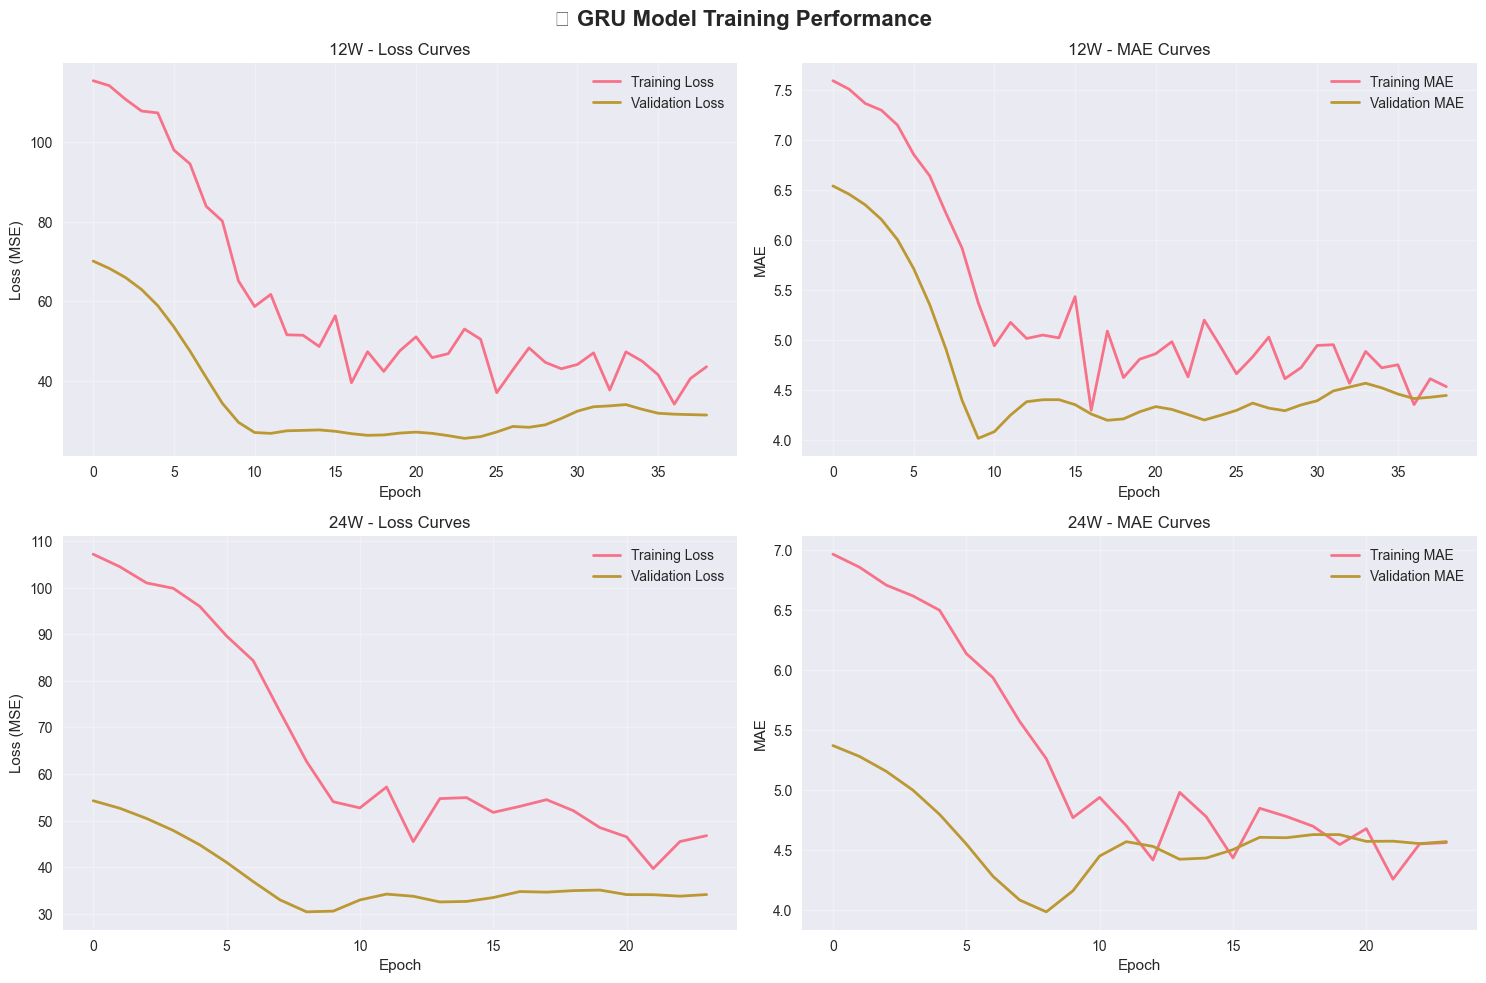


🏗️ GRU Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 33)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 1, 64)          │        19,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,269 (340.90 KB)

 Trainable params: 29,089 (113.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,180 (227.27 KB)

In [5]:
# 📊 Training Performance Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('🧠 GRU Model Training Performance', fontsize=16, fontweight='bold')

for idx, (target_name, history) in enumerate(training_history.items()):
    # Loss curves
    axes[idx, 0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[idx, 0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[idx, 0].set_title(f'{target_name.upper()} - Loss Curves')
    axes[idx, 0].set_xlabel('Epoch')
    axes[idx, 0].set_ylabel('Loss (MSE)')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # MAE curves
    axes[idx, 1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[idx, 1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[idx, 1].set_title(f'{target_name.upper()} - MAE Curves')
    axes[idx, 1].set_xlabel('Epoch')
    axes[idx, 1].set_ylabel('MAE')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Model architecture summary
print("\n🏗️ GRU Model Architecture:")
models['12w'].summary()

In [6]:
# 🔍 SHAP Analysis - Global Feature Importance
print("🔍 Computing SHAP values for feature importance analysis...")

# Initialize SHAP explainer with the 12w model (primary target)
# Use a subset of data for SHAP computation (computational efficiency)
X_sample = X_scaled[:100]  # Sample for background
X_explain = X_scaled[:50]  # Sample to explain

# Create SHAP explainer for deep learning model
explainer_12w = shap.Explainer(models['12w'], X_sample)
shap_values_12w = explainer_12w(X_explain)

explainer_24w = shap.Explainer(models['24w'], X_sample)
shap_values_24w = explainer_24w(X_explain)

print("✅ SHAP values computed successfully!")
print(f"   SHAP values shape (12w): {shap_values_12w.values.shape}")
print(f"   SHAP values shape (24w): {shap_values_24w.values.shape}")

🔍 Computing SHAP values for feature importance analysis...


PermutationExplainer explainer: 51it [00:30,  1.01s/it]                        

PermutationExplainer explainer: 51it [00:17,  1.22it/s]                        

✅ SHAP values computed successfully!
   SHAP values shape (12w): (50, 33)
   SHAP values shape (24w): (50, 33)


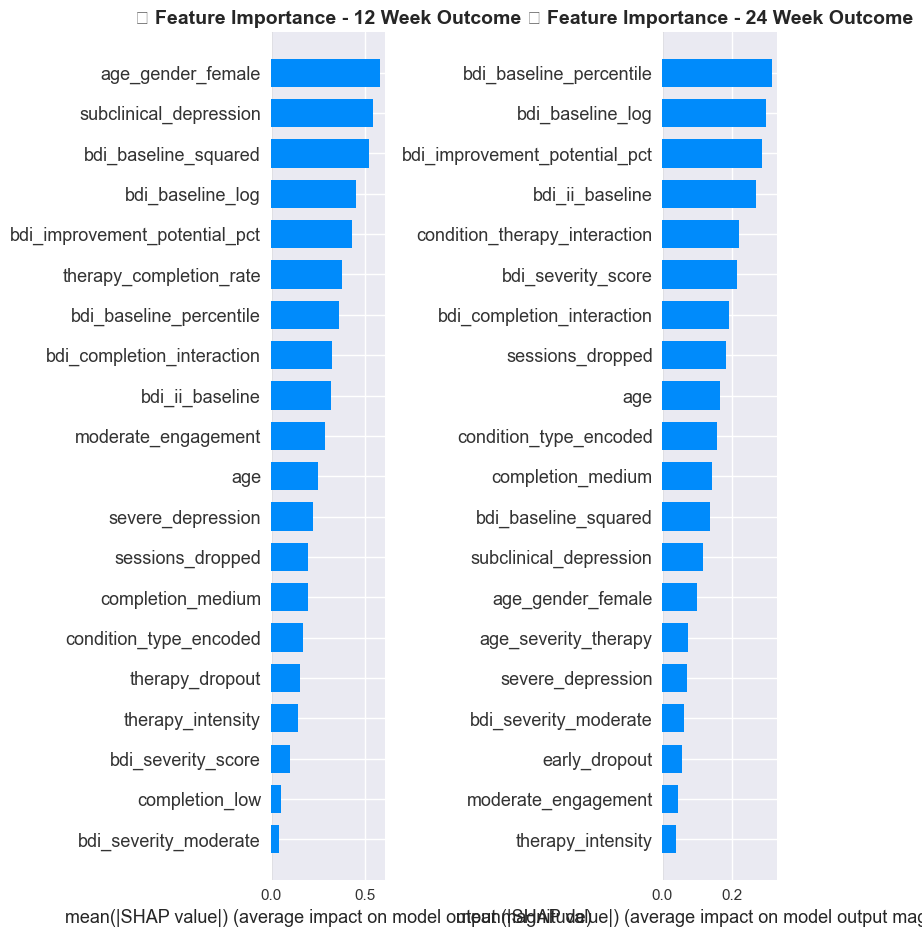


🏆 Top 10 Most Important Features:

📅 12-Week Outcome:
 1. age_gender_female              | Importance: 0.5806
 2. subclinical_depression         | Importance: 0.5425
 3. bdi_baseline_squared           | Importance: 0.5257
 4. bdi_baseline_log               | Importance: 0.4541
 5. bdi_improvement_potential_pct  | Importance: 0.4344
 6. therapy_completion_rate        | Importance: 0.3808
 7. bdi_baseline_percentile        | Importance: 0.3618
 8. bdi_completion_interaction     | Importance: 0.3249
 9. bdi_ii_baseline                | Importance: 0.3203
10. moderate_engagement            | Importance: 0.2915

📅 24-Week Outcome:
 1. bdi_baseline_percentile        | Importance: 0.3133
 2. bdi_baseline_log               | Importance: 0.2964
 3. bdi_improvement_potential_pct  | Importance: 0.2850
 4. bdi_ii_baseline                | Importance: 0.2680
 5. condition_therapy_interaction  | Importance: 0.2190
 6. bdi_severity_score             | Importance: 0.2150
 7. bdi_completion_interactio

In [7]:
# 📈 SHAP Summary Plots - Feature Importance Ranking
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# 12w target SHAP summary
plt.sca(axes[0])
shap.summary_plot(
    shap_values_12w.values, 
    features=X_explain, 
    feature_names=feature_cols,
    plot_type="bar",
    show=False
)
axes[0].set_title('🎯 Feature Importance - 12 Week Outcome', fontsize=14, fontweight='bold')

# 24w target SHAP summary
plt.sca(axes[1])
shap.summary_plot(
    shap_values_24w.values, 
    features=X_explain, 
    feature_names=feature_cols,
    plot_type="bar",
    show=False
)
axes[1].set_title('🎯 Feature Importance - 24 Week Outcome', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Extract top features for both targets
feature_importance_12w = np.abs(shap_values_12w.values).mean(axis=0)
feature_importance_24w = np.abs(shap_values_24w.values).mean(axis=0)

# Create importance dataframes
importance_df_12w = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance_12w
}).sort_values('importance', ascending=False)

importance_df_24w = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance_24w
}).sort_values('importance', ascending=False)

print("\n🏆 Top 10 Most Important Features:")
print("\n📅 12-Week Outcome:")
for i, (_, row) in enumerate(importance_df_12w.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<30} | Importance: {row['importance']:.4f}")

print("\n📅 24-Week Outcome:")
for i, (_, row) in enumerate(importance_df_24w.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<30} | Importance: {row['importance']:.4f}")

In [8]:
# 🔄 Permutation Importance Analysis
print("🔄 Computing permutation importance...")

from sklearn.base import BaseEstimator, RegressorMixin

class KerasWrapper(BaseEstimator, RegressorMixin):
    """Wrapper to make Keras model compatible with sklearn"""
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        # Dummy fit method for sklearn compatibility
        return self
    
    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_absolute_error(y, y_pred)  # negative MAE for scoring

# Wrap models
wrapper_12w = KerasWrapper(models['12w'])
wrapper_24w = KerasWrapper(models['24w'])

# Compute permutation importance on validation sets
X_train_12w, X_val_12w, y_train_12w, y_val_12w = train_test_split(
    X_scaled, y_12w, test_size=0.2, random_state=42
)
X_train_24w, X_val_24w, y_train_24w, y_val_24w = train_test_split(
    X_scaled, y_24w, test_size=0.2, random_state=42
)

# Permutation importance
perm_importance_12w = permutation_importance(
    wrapper_12w, X_val_12w, y_val_12w, 
    n_repeats=5, random_state=42, scoring='neg_mean_absolute_error'
)

perm_importance_24w = permutation_importance(
    wrapper_24w, X_val_24w, y_val_24w, 
    n_repeats=5, random_state=42, scoring='neg_mean_absolute_error'
)

# Create permutation importance dataframes
perm_df_12w = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': perm_importance_12w.importances_mean,
    'importance_std': perm_importance_12w.importances_std
}).sort_values('importance_mean', ascending=False)

perm_df_24w = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': perm_importance_24w.importances_mean,
    'importance_std': perm_importance_24w.importances_std
}).sort_values('importance_mean', ascending=False)

print("✅ Permutation importance computed!")

🔄 Computing permutation importance...
✅ Permutation importance computed!
✅ Permutation importance computed!


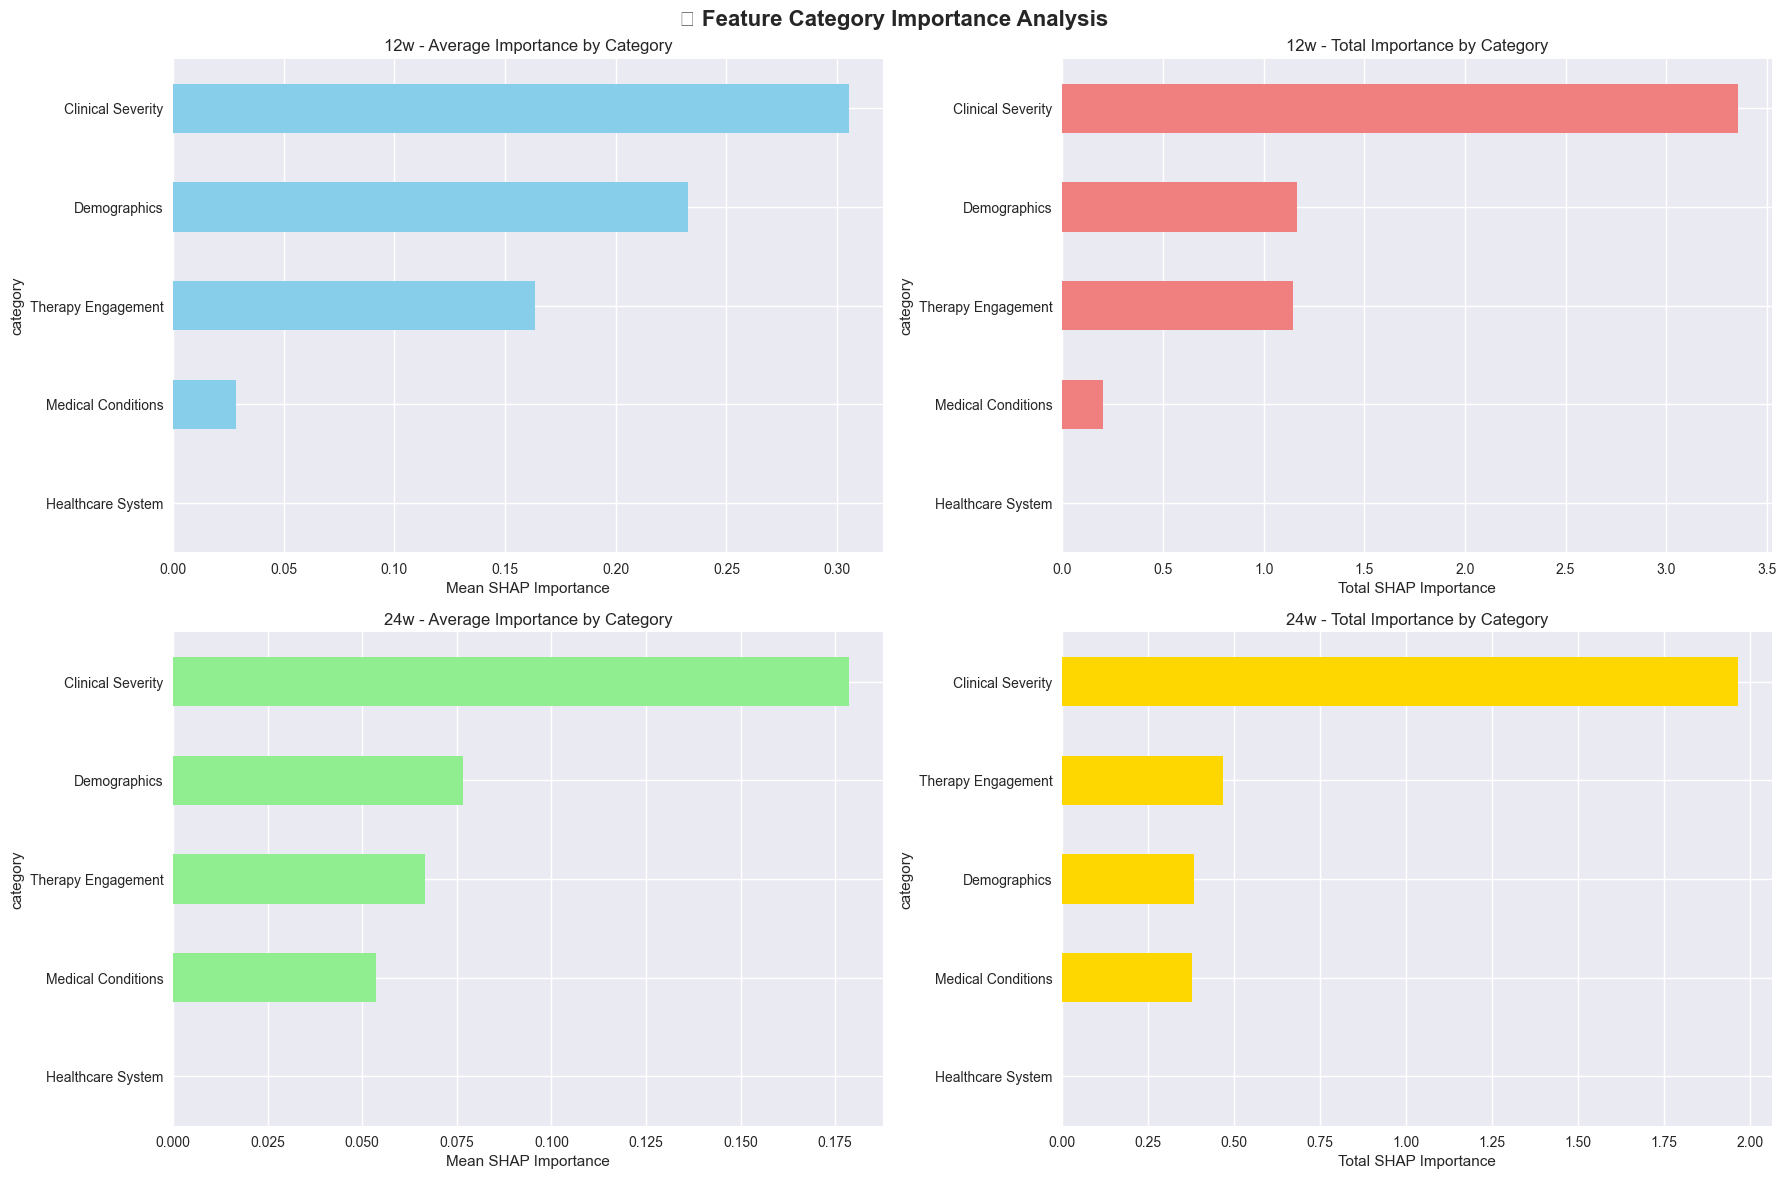


📈 Category Importance Summary:

🎯 12-Week Outcome:
                      mean     sum  count
category                                 
Clinical Severity   0.3054  3.3592     11
Demographics        0.2327  1.1633      5
Therapy Engagement  0.1634  1.1436      7
Medical Conditions  0.0286  0.1999      7
Healthcare System   0.0000  0.0000      3

🎯 24-Week Outcome:
                      mean     sum  count
category                                 
Clinical Severity   0.1787  1.9660     11
Demographics        0.0767  0.3833      5
Therapy Engagement  0.0667  0.4670      7
Medical Conditions  0.0537  0.3758      7
Healthcare System   0.0000  0.0000      3


In [9]:
# 🎪 Feature Category Analysis
def categorize_features(feature_name):
    """Categorize features based on their names"""
    feature_lower = feature_name.lower()
    
    if any(term in feature_lower for term in ['age', 'gender']):
        return 'Demographics'
    elif any(term in feature_lower for term in ['bdi', 'depression', 'severity']):
        return 'Clinical Severity'
    elif 'condition' in feature_lower:
        return 'Medical Conditions'
    elif any(term in feature_lower for term in ['therapy', 'completion', 'session', 'dropout']):
        return 'Therapy Engagement'
    elif 'hospital' in feature_lower:
        return 'Healthcare System'
    else:
        return 'Other'

# Add categories to importance dataframes
importance_df_12w['category'] = importance_df_12w['feature'].apply(categorize_features)
importance_df_24w['category'] = importance_df_24w['feature'].apply(categorize_features)

# Category-wise importance analysis
category_importance_12w = importance_df_12w.groupby('category')['importance'].agg(['mean', 'sum', 'count']).round(4)
category_importance_24w = importance_df_24w.groupby('category')['importance'].agg(['mean', 'sum', 'count']).round(4)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('📊 Feature Category Importance Analysis', fontsize=16, fontweight='bold')

# 12w category importance
category_importance_12w['mean'].sort_values(ascending=True).plot(kind='barh', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('12w - Average Importance by Category')
axes[0,0].set_xlabel('Mean SHAP Importance')

category_importance_12w['sum'].sort_values(ascending=True).plot(kind='barh', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('12w - Total Importance by Category')
axes[0,1].set_xlabel('Total SHAP Importance')

# 24w category importance
category_importance_24w['mean'].sort_values(ascending=True).plot(kind='barh', ax=axes[1,0], color='lightgreen')
axes[1,0].set_title('24w - Average Importance by Category')
axes[1,0].set_xlabel('Mean SHAP Importance')

category_importance_24w['sum'].sort_values(ascending=True).plot(kind='barh', ax=axes[1,1], color='gold')
axes[1,1].set_title('24w - Total Importance by Category')
axes[1,1].set_xlabel('Total SHAP Importance')

plt.tight_layout()
plt.show()

print("\n📈 Category Importance Summary:")
print("\n🎯 12-Week Outcome:")
print(category_importance_12w.sort_values('mean', ascending=False))
print("\n🎯 24-Week Outcome:")
print(category_importance_24w.sort_values('mean', ascending=False))

In [11]:
# 🔄 Permutation Importance Analysis
print("🔄 Computing permutation importance...")

# Note: BaseEstimator and RegressorMixin were already imported above,
# so we avoid re-importing them here to prevent duplicate imports.

class KerasWrapper(BaseEstimator, RegressorMixin):
    """Wrapper to make Keras model compatible with sklearn's permutation_importance.
    
    Implements a no-op fit method so sklearn recognizes this as an estimator.
    """
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y=None):
        # No training is performed here; wrapper only exposes fit for sklearn compatibility.
        return self
    
    def predict(self, X):
        return self.model.predict(X, verbose=0).flatten()
    
    def score(self, X, y):
        # Provide a score method (optional). Return negative MAE to be consistent with earlier scoring.
        y_pred = self.predict(X)
        return -mean_absolute_error(y, y_pred)

# Wrap models
wrapper_12w = KerasWrapper(models['12w'])
wrapper_24w = KerasWrapper(models['24w'])

# Compute permutation importance on validation sets
X_train_12w, X_val_12w, y_train_12w, y_val_12w = train_test_split(
    X_scaled, y_12w, test_size=0.2, random_state=42
)
X_train_24w, X_val_24w, y_train_24w, y_val_24w = train_test_split(
    X_scaled, y_24w, test_size=0.2, random_state=42
)

# Permutation importance
perm_importance_12w = permutation_importance(
    wrapper_12w, X_val_12w, y_val_12w, 
    n_repeats=10, random_state=42, scoring='neg_mean_absolute_error'
)

perm_importance_24w = permutation_importance(
    wrapper_24w, X_val_24w, y_val_24w, 
    n_repeats=10, random_state=42, scoring='neg_mean_absolute_error'
)

# Create permutation importance dataframes
perm_df_12w = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': perm_importance_12w.importances_mean,
    'importance_std': perm_importance_12w.importances_std
}).sort_values('importance_mean', ascending=False)

perm_df_24w = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': perm_importance_24w.importances_mean,
    'importance_std': perm_importance_24w.importances_std
}).sort_values('importance_mean', ascending=False)

print("✅ Permutation importance computed!")

🔄 Computing permutation importance...
✅ Permutation importance computed!
✅ Permutation importance computed!


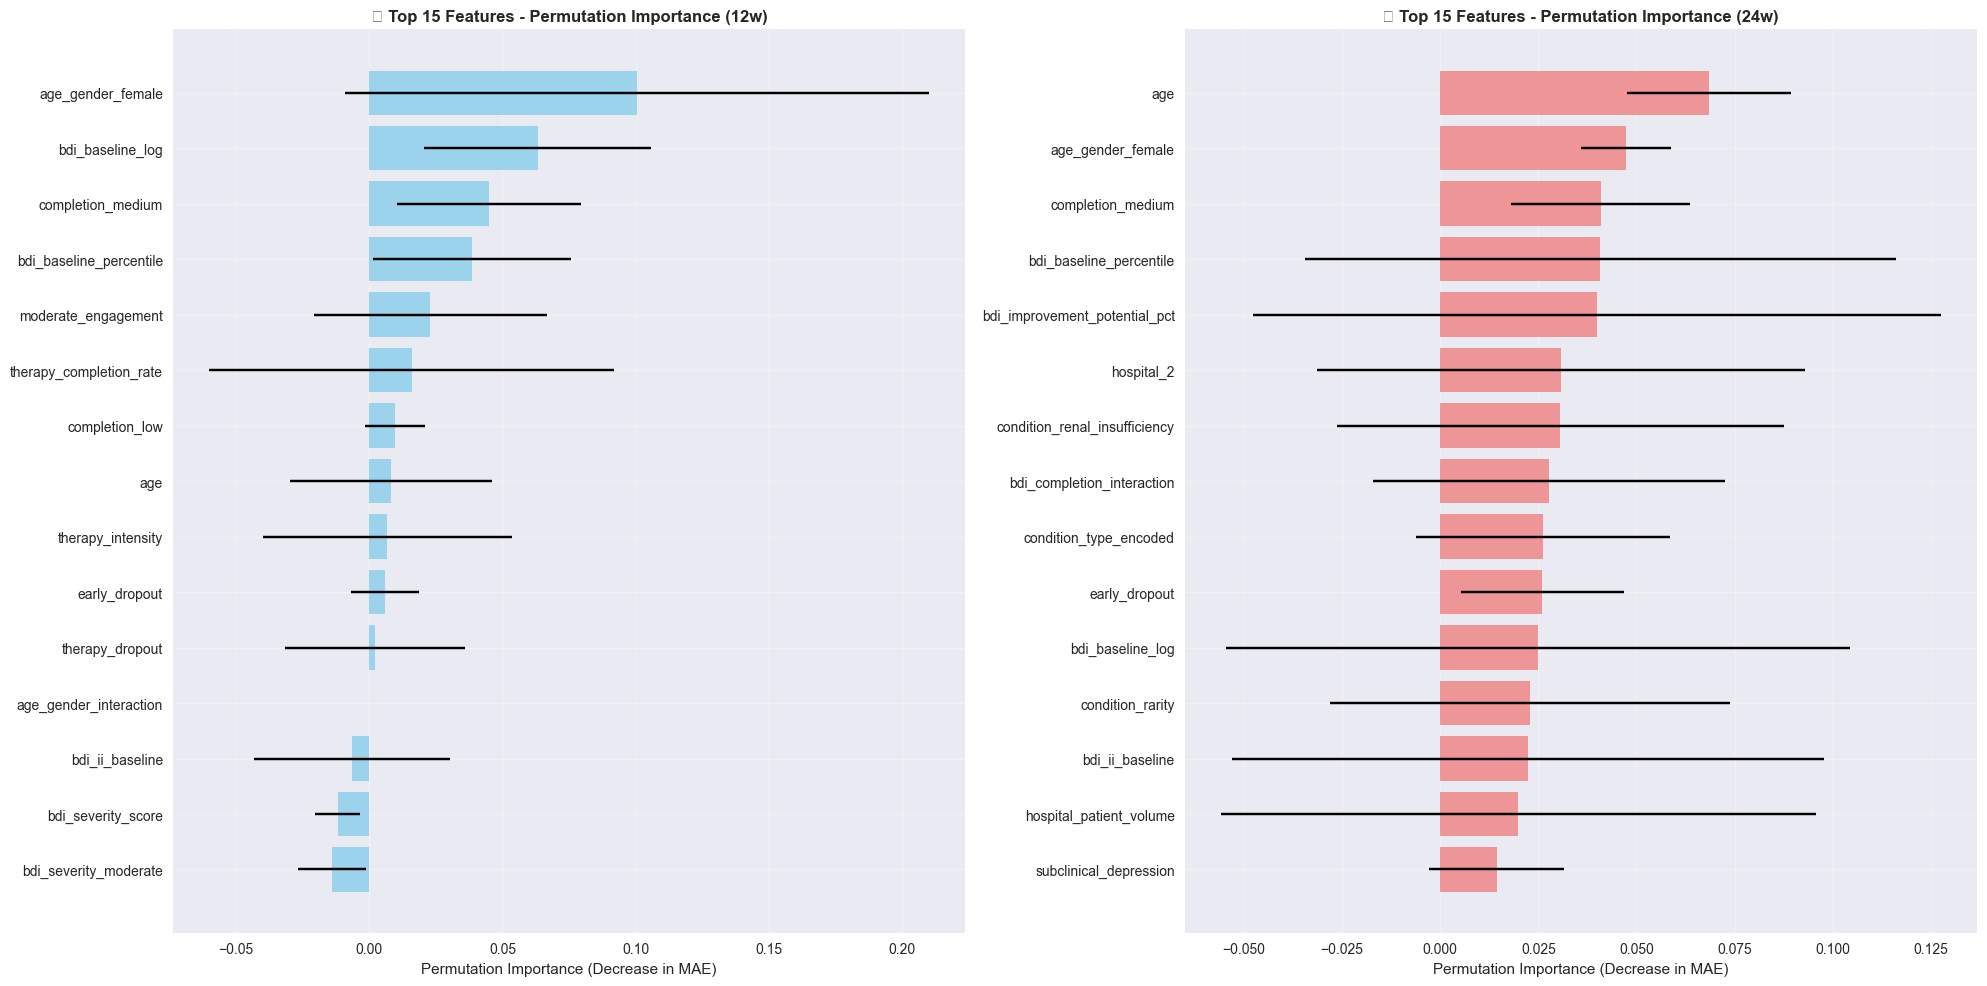


🏆 Top 10 Features by Permutation Importance:

📅 12-Week Outcome:
 1. age_gender_female              | Importance: 0.1004 ± 0.1096
 2. bdi_baseline_log               | Importance: 0.0632 ± 0.0425
 3. completion_medium              | Importance: 0.0450 ± 0.0345
 4. bdi_baseline_percentile        | Importance: 0.0386 ± 0.0373
 5. moderate_engagement            | Importance: 0.0230 ± 0.0436
 6. therapy_completion_rate        | Importance: 0.0159 ± 0.0760
 7. completion_low                 | Importance: 0.0098 ± 0.0113
 8. age                            | Importance: 0.0082 ± 0.0380
 9. therapy_intensity              | Importance: 0.0069 ± 0.0466
10. early_dropout                  | Importance: 0.0058 ± 0.0128

📅 24-Week Outcome:
 1. age                            | Importance: 0.0684 ± 0.0209
 2. age_gender_female              | Importance: 0.0473 ± 0.0116
 3. completion_medium              | Importance: 0.0409 ± 0.0228
 4. bdi_baseline_percentile        | Importance: 0.0408 ± 0.0753
 5. 

In [12]:
# 📊 Permutation Importance Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Top 15 features for each target
top_15_12w = perm_df_12w.head(15)
top_15_24w = perm_df_24w.head(15)

# 12w permutation importance
axes[0].barh(range(len(top_15_12w)), top_15_12w['importance_mean'], 
             xerr=top_15_12w['importance_std'], color='skyblue', alpha=0.8)
axes[0].set_yticks(range(len(top_15_12w)))
axes[0].set_yticklabels(top_15_12w['feature'], fontsize=10)
axes[0].set_xlabel('Permutation Importance (Decrease in MAE)')
axes[0].set_title('🎯 Top 15 Features - Permutation Importance (12w)', fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].invert_yaxis()

# 24w permutation importance
axes[1].barh(range(len(top_15_24w)), top_15_24w['importance_mean'], 
             xerr=top_15_24w['importance_std'], color='lightcoral', alpha=0.8)
axes[1].set_yticks(range(len(top_15_24w)))
axes[1].set_yticklabels(top_15_24w['feature'], fontsize=10)
axes[1].set_xlabel('Permutation Importance (Decrease in MAE)')
axes[1].set_title('🎯 Top 15 Features - Permutation Importance (24w)', fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n🏆 Top 10 Features by Permutation Importance:")
print("\n📅 12-Week Outcome:")
for i, (_, row) in enumerate(perm_df_12w.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<30} | Importance: {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")

print("\n📅 24-Week Outcome:")
for i, (_, row) in enumerate(perm_df_24w.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<30} | Importance: {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")

🔗 Analyzing feature correlations and interactions...


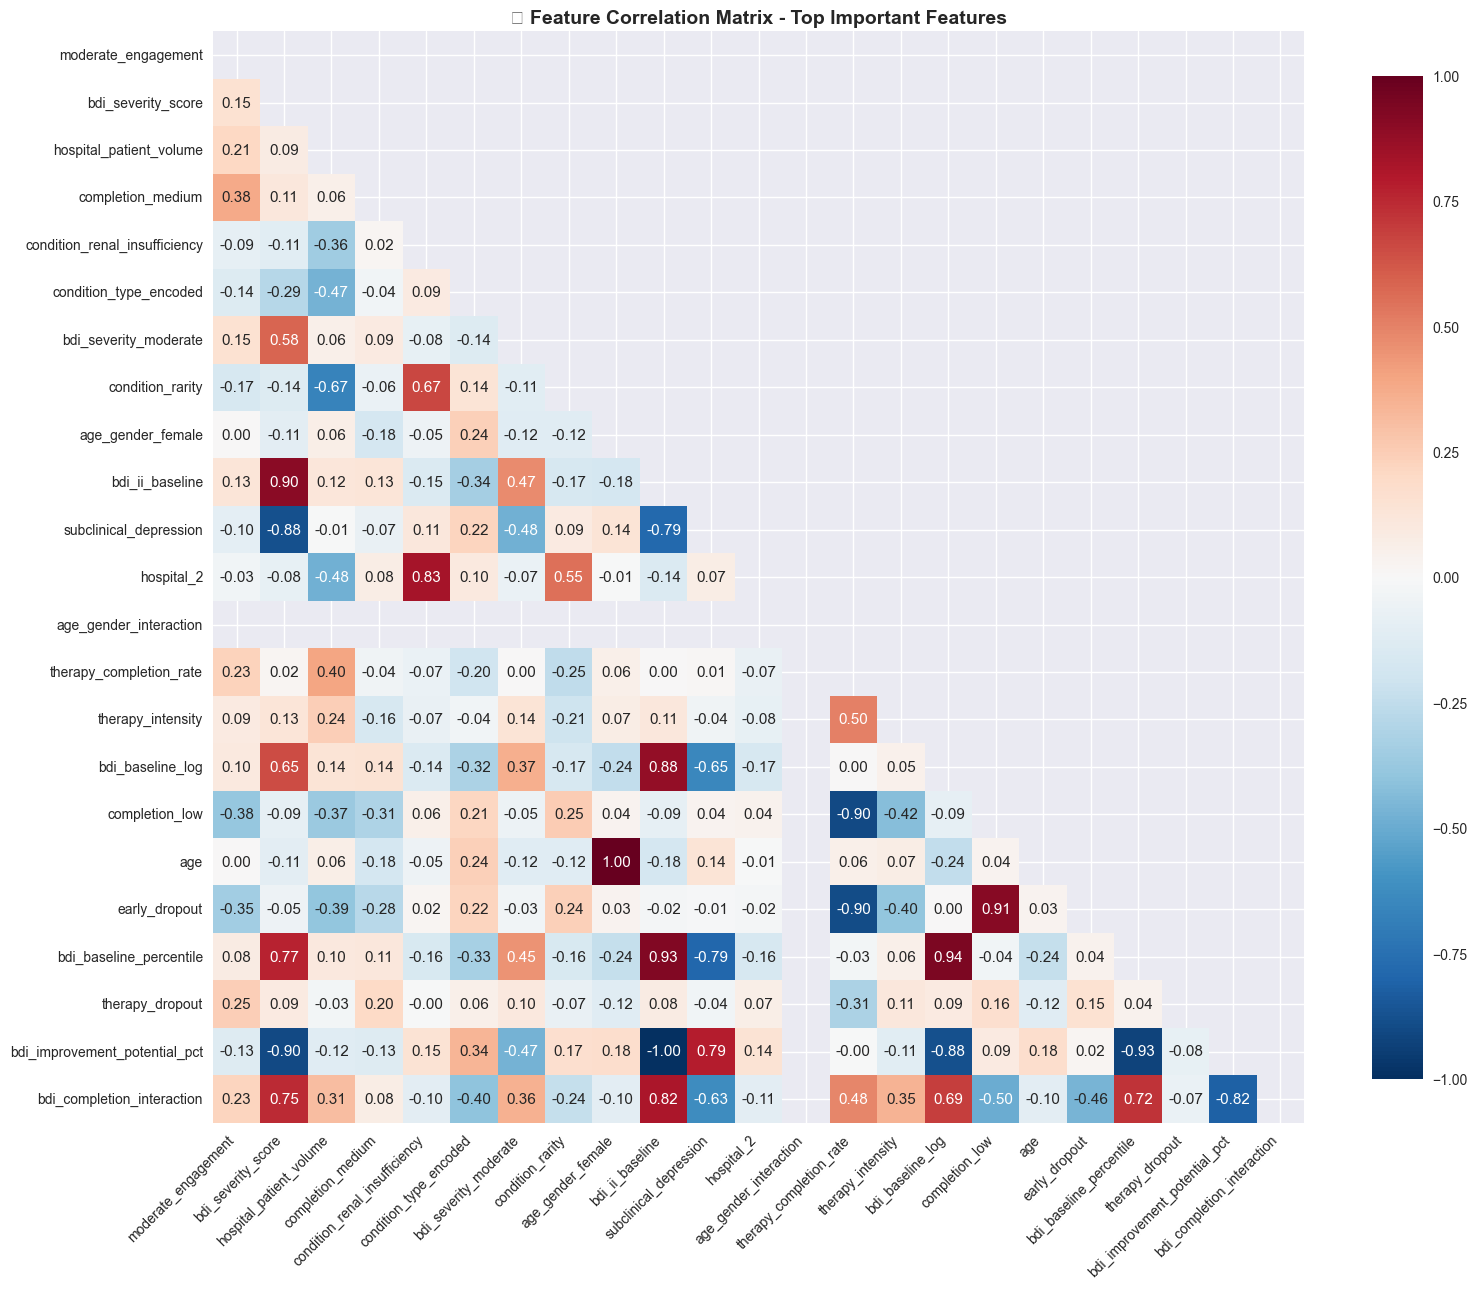


⚠️ Highly Correlated Feature Pairs (|r| > 0.7):
   bdi_ii_baseline ↔ bdi_improvement_potential_pct: r = -1.000
   age_gender_female ↔ age: r = 1.000
   bdi_baseline_log ↔ bdi_baseline_percentile: r = 0.944
   bdi_ii_baseline ↔ bdi_baseline_percentile: r = 0.928
   bdi_baseline_percentile ↔ bdi_improvement_potential_pct: r = -0.928
   completion_low ↔ early_dropout: r = 0.907
   therapy_completion_rate ↔ completion_low: r = -0.902
   bdi_severity_score ↔ bdi_improvement_potential_pct: r = -0.899
   bdi_severity_score ↔ bdi_ii_baseline: r = 0.899
   therapy_completion_rate ↔ early_dropout: r = -0.897
   bdi_severity_score ↔ subclinical_depression: r = -0.877
   bdi_ii_baseline ↔ bdi_baseline_log: r = 0.875
   bdi_baseline_log ↔ bdi_improvement_potential_pct: r = -0.875
   condition_renal_insufficiency ↔ hospital_2: r = 0.829
   bdi_ii_baseline ↔ bdi_completion_interaction: r = 0.817
   bdi_improvement_potential_pct ↔ bdi_completion_interaction: r = -0.817
   subclinical_depression ↔ bdi

In [13]:
# 🔗 Feature Correlation and Interaction Analysis
print("🔗 Analyzing feature correlations and interactions...")

# Calculate correlation matrix
feature_data = pd.DataFrame(X_scaled, columns=feature_cols)
correlation_matrix = feature_data.corr()

# Get top important features for correlation analysis
top_features_12w = perm_df_12w.head(15)['feature'].tolist()
top_features_24w = perm_df_24w.head(15)['feature'].tolist()
top_features_combined = list(set(top_features_12w + top_features_24w))

# Focus on correlations among top features
top_correlation_matrix = correlation_matrix.loc[top_features_combined, top_features_combined]

# Visualization
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(top_correlation_matrix, dtype=bool))
sns.heatmap(top_correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})
plt.title('🔗 Feature Correlation Matrix - Top Important Features', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(top_correlation_matrix.columns)):
    for j in range(i+1, len(top_correlation_matrix.columns)):
        corr_val = abs(top_correlation_matrix.iloc[i, j])
        if corr_val > 0.7:  # High correlation threshold
            high_corr_pairs.append({
                'feature1': top_correlation_matrix.columns[i],
                'feature2': top_correlation_matrix.columns[j],
                'correlation': top_correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print("\n⚠️ Highly Correlated Feature Pairs (|r| > 0.7):")
    for pair in sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True):
        print(f"   {pair['feature1']} ↔ {pair['feature2']}: r = {pair['correlation']:.3f}")
else:
    print("\n✅ No highly correlated feature pairs found among top features.")

🎯 Comparing SHAP and Permutation Importance...


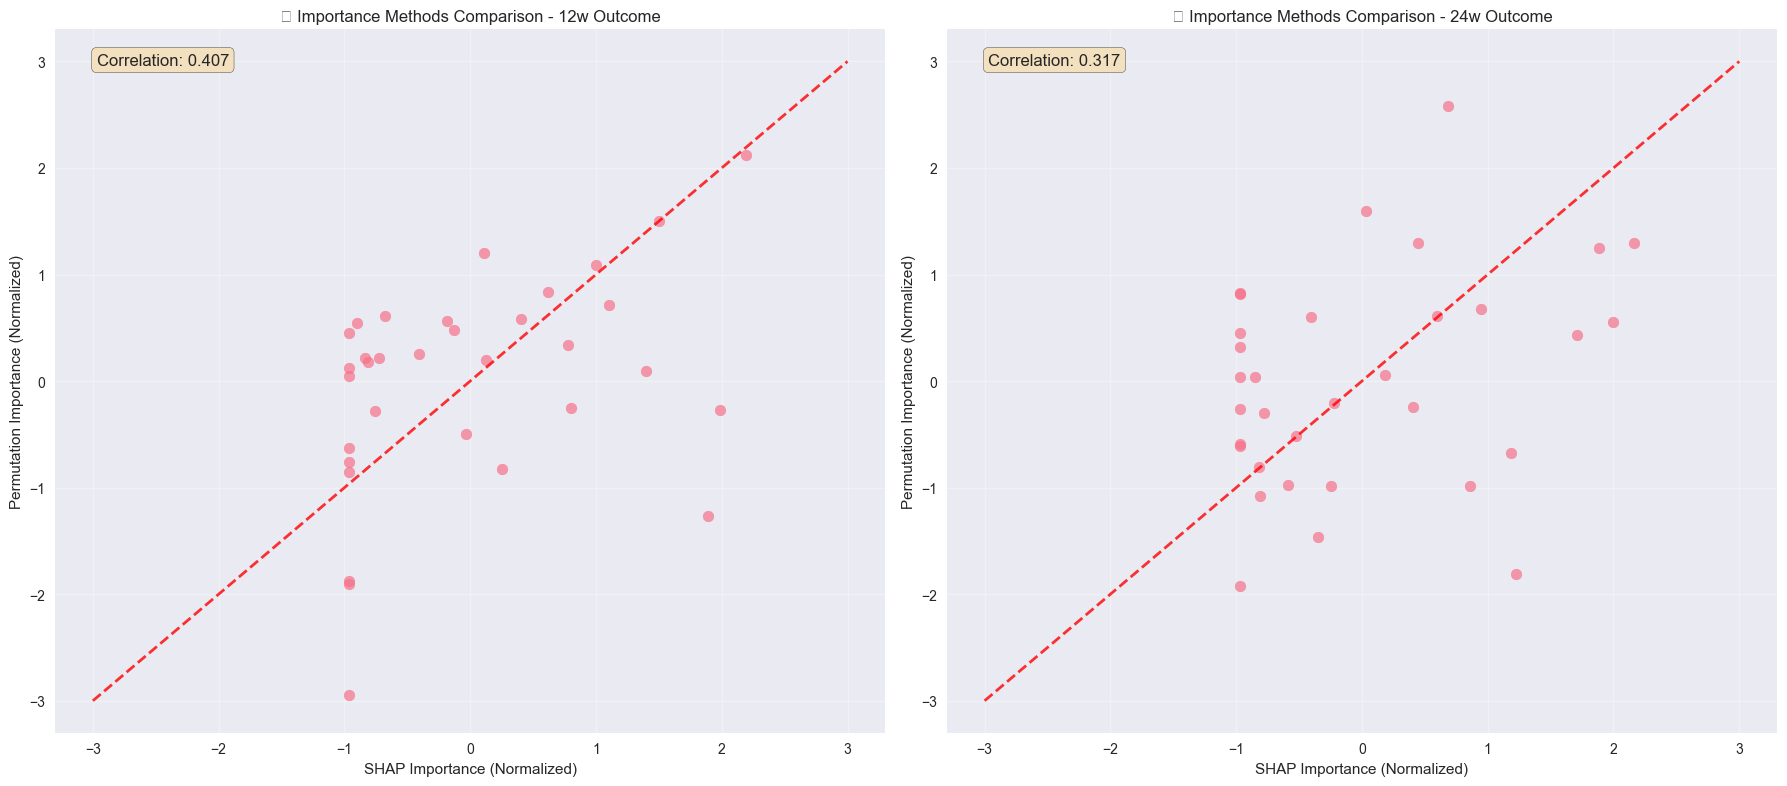


📊 Method Correlation Analysis:
   12w outcome - SHAP vs Permutation correlation: 0.407
   24w outcome - SHAP vs Permutation correlation: 0.317


In [14]:
# 🎯 Feature Importance Comparison: SHAP vs Permutation
print("🎯 Comparing SHAP and Permutation Importance...")

# Merge SHAP and permutation importance for comparison
comparison_12w = pd.merge(
    importance_df_12w[['feature', 'importance']].rename(columns={'importance': 'shap_importance'}),
    perm_df_12w[['feature', 'importance_mean']].rename(columns={'importance_mean': 'perm_importance'}),
    on='feature'
)

comparison_24w = pd.merge(
    importance_df_24w[['feature', 'importance']].rename(columns={'importance': 'shap_importance'}),
    perm_df_24w[['feature', 'importance_mean']].rename(columns={'importance_mean': 'perm_importance'}),
    on='feature'
)

# Normalize importance scores for comparison
from sklearn.preprocessing import StandardScaler
scaler_comp = StandardScaler()

comparison_12w['shap_norm'] = scaler_comp.fit_transform(comparison_12w[['shap_importance']])[:, 0]
comparison_12w['perm_norm'] = scaler_comp.fit_transform(comparison_12w[['perm_importance']])[:, 0]

comparison_24w['shap_norm'] = scaler_comp.fit_transform(comparison_24w[['shap_importance']])[:, 0]
comparison_24w['perm_norm'] = scaler_comp.fit_transform(comparison_24w[['perm_importance']])[:, 0]

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 12w comparison
axes[0].scatter(comparison_12w['shap_norm'], comparison_12w['perm_norm'], alpha=0.7, s=60)
axes[0].plot([-3, 3], [-3, 3], 'r--', alpha=0.8, linewidth=2)
axes[0].set_xlabel('SHAP Importance (Normalized)')
axes[0].set_ylabel('Permutation Importance (Normalized)')
axes[0].set_title('🎯 Importance Methods Comparison - 12w Outcome')
axes[0].grid(True, alpha=0.3)

# Add correlation coefficient
corr_12w = comparison_12w['shap_norm'].corr(comparison_12w['perm_norm'])
axes[0].text(0.05, 0.95, f'Correlation: {corr_12w:.3f}', 
             transform=axes[0].transAxes, fontsize=12, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 24w comparison
axes[1].scatter(comparison_24w['shap_norm'], comparison_24w['perm_norm'], alpha=0.7, s=60)
axes[1].plot([-3, 3], [-3, 3], 'r--', alpha=0.8, linewidth=2)
axes[1].set_xlabel('SHAP Importance (Normalized)')
axes[1].set_ylabel('Permutation Importance (Normalized)')
axes[1].set_title('🎯 Importance Methods Comparison - 24w Outcome')
axes[1].grid(True, alpha=0.3)

corr_24w = comparison_24w['shap_norm'].corr(comparison_24w['perm_norm'])
axes[1].text(0.05, 0.95, f'Correlation: {corr_24w:.3f}', 
             transform=axes[1].transAxes, fontsize=12, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\n📊 Method Correlation Analysis:")
print(f"   12w outcome - SHAP vs Permutation correlation: {corr_12w:.3f}")
print(f"   24w outcome - SHAP vs Permutation correlation: {corr_24w:.3f}")

In [15]:
# 📋 Comprehensive Feature Importance Summary
print("📋 Creating comprehensive feature importance summary...")

# Create final summary dataframe
def create_summary_table(shap_df, perm_df, target_name):
    summary = pd.merge(
        shap_df[['feature', 'importance', 'category']].rename(columns={'importance': 'shap_importance'}),
        perm_df[['feature', 'importance_mean', 'importance_std']].rename(columns={
            'importance_mean': 'perm_importance',
            'importance_std': 'perm_std'
        }),
        on='feature'
    )
    
    # Rank features by both methods
    summary['shap_rank'] = summary['shap_importance'].rank(ascending=False, method='min')
    summary['perm_rank'] = summary['perm_importance'].rank(ascending=False, method='min')
    summary['avg_rank'] = (summary['shap_rank'] + summary['perm_rank']) / 2
    summary['rank_difference'] = abs(summary['shap_rank'] - summary['perm_rank'])
    
    return summary.sort_values('avg_rank')

summary_12w = create_summary_table(importance_df_12w, perm_df_12w, '12w')
summary_24w = create_summary_table(importance_df_24w, perm_df_24w, '24w')

# Display top 15 features for each target
print("\n🏆 TOP 15 FEATURES - COMPREHENSIVE RANKING")
print("\n" + "="*80)
print("📅 12-WEEK OUTCOME")
print("="*80)
print(f"{'Rank':<4} {'Feature':<25} {'Category':<15} {'SHAP':<8} {'Perm':<8} {'Avg':<6}")
print("-"*80)

for i, (_, row) in enumerate(summary_12w.head(15).iterrows(), 1):
    print(f"{i:<4} {row['feature'][:24]:<25} {row['category'][:14]:<15} "
          f"{row['shap_rank']:<8.0f} {row['perm_rank']:<8.0f} {row['avg_rank']:<6.1f}")

print("\n" + "="*80)
print("📅 24-WEEK OUTCOME")
print("="*80)
print(f"{'Rank':<4} {'Feature':<25} {'Category':<15} {'SHAP':<8} {'Perm':<8} {'Avg':<6}")
print("-"*80)

for i, (_, row) in enumerate(summary_24w.head(15).iterrows(), 1):
    print(f"{i:<4} {row['feature'][:24]:<25} {row['category'][:14]:<15} "
          f"{row['shap_rank']:<8.0f} {row['perm_rank']:<8.0f} {row['avg_rank']:<6.1f}")

# Save results
summary_12w.to_csv(BASE_PATH / 'Results' / 'feature_importance_12w_summary.csv', index=False)
summary_24w.to_csv(BASE_PATH / 'Results' / 'feature_importance_24w_summary.csv', index=False)

print("\n💾 Results saved to CSV files!")

📋 Creating comprehensive feature importance summary...

🏆 TOP 15 FEATURES - COMPREHENSIVE RANKING

📅 12-WEEK OUTCOME
Rank Feature                   Category        SHAP     Perm     Avg   
--------------------------------------------------------------------------------
1    age_gender_female         Demographics    1        1        1.0   
2    bdi_baseline_log          Clinical Sever  4        2        3.0   
3    bdi_baseline_percentile   Clinical Sever  7        4        5.5   
4    therapy_completion_rate   Therapy Engage  6        6        6.0   
5    moderate_engagement       Demographics    10       5        7.5   
6    completion_medium         Therapy Engage  14       3        8.5   
7    age                       Demographics    11       8        9.5   
8    bdi_ii_baseline           Clinical Sever  9        13       11.0  
9    subclinical_depression    Clinical Sever  2        23       12.5  
10   bdi_improvement_potentia  Clinical Sever  5        20       12.5  
11   compl

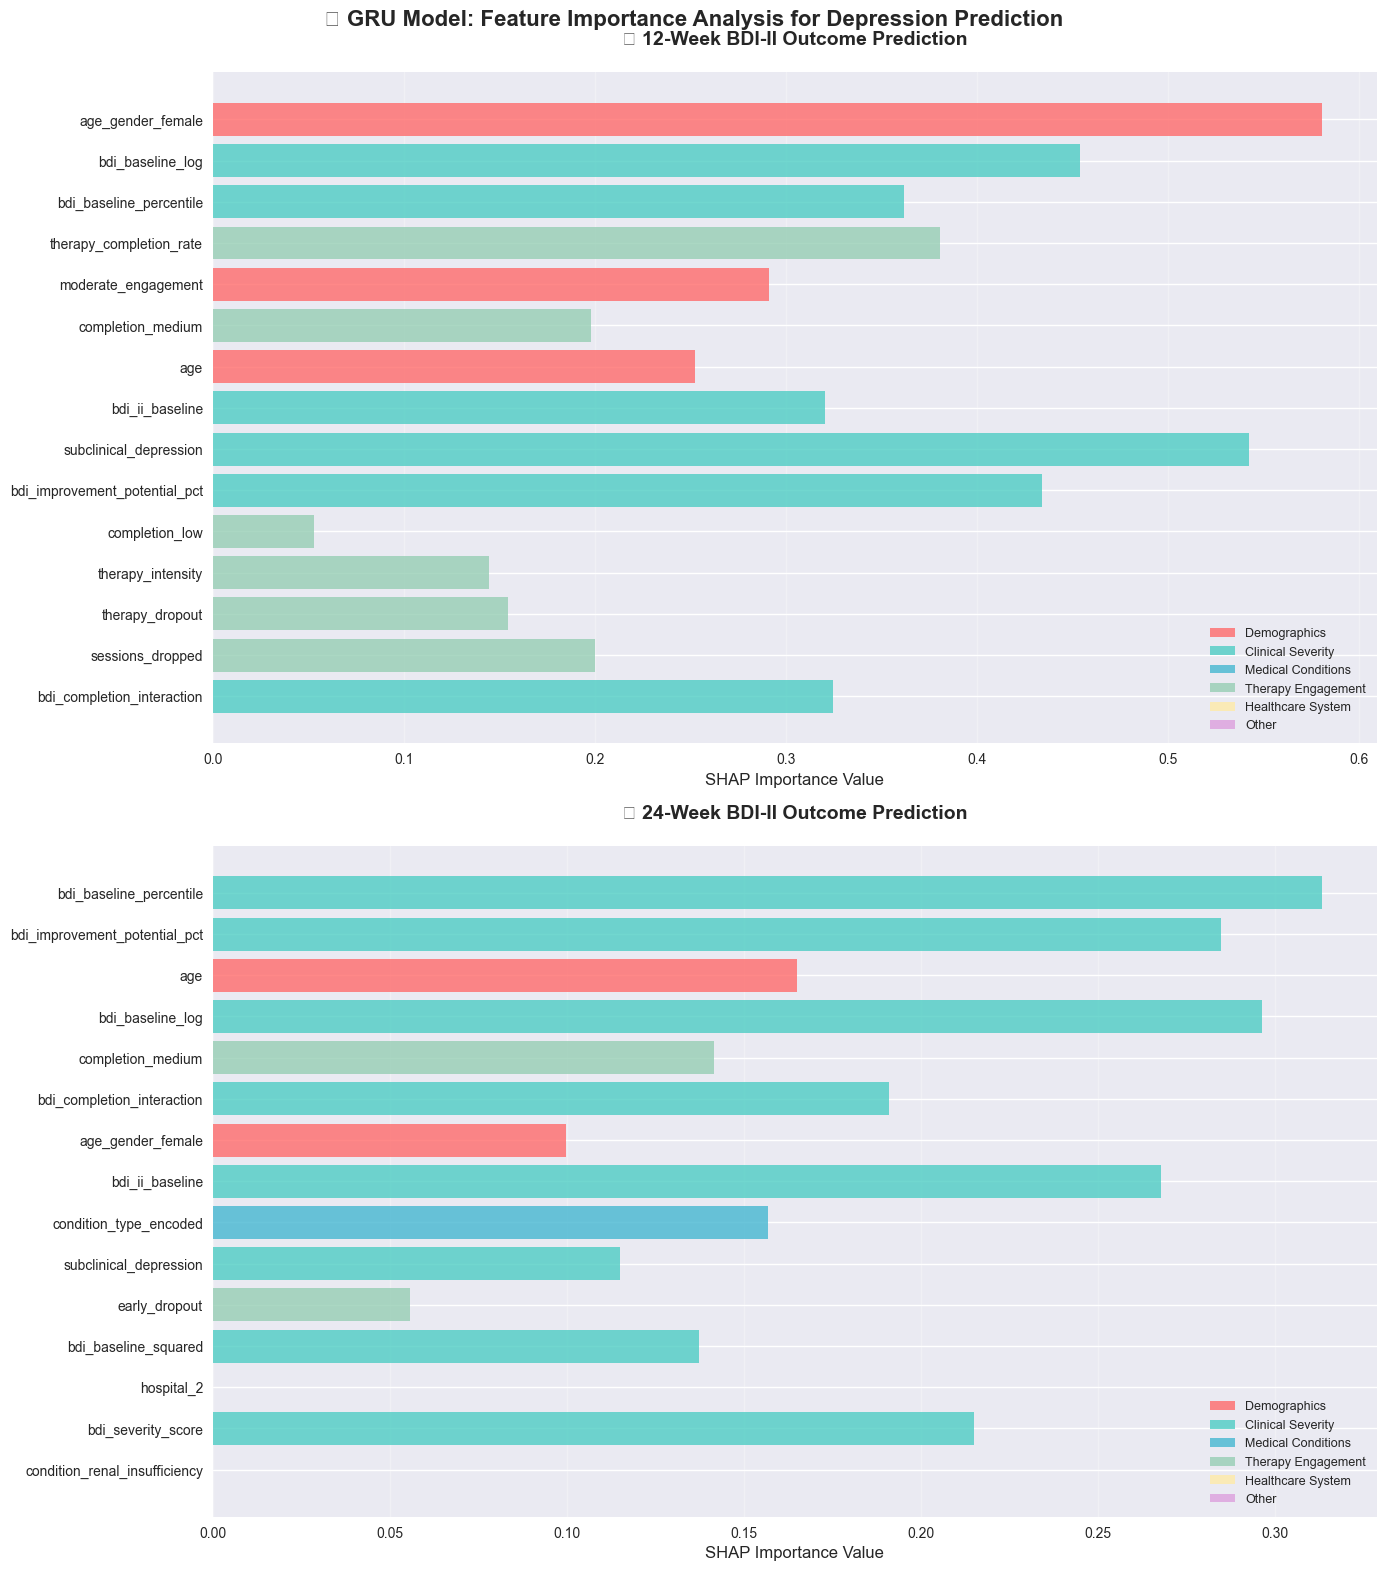


🎨 Publication-ready plot saved!


In [16]:
# 🎨 Create Publication-Ready Feature Importance Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 16))
fig.suptitle('🧠 GRU Model: Feature Importance Analysis for Depression Prediction', 
             fontsize=16, fontweight='bold', y=0.98)

# Define colors for categories
category_colors = {
    'Demographics': '#FF6B6B',
    'Clinical Severity': '#4ECDC4', 
    'Medical Conditions': '#45B7D1',
    'Therapy Engagement': '#96CEB4',
    'Healthcare System': '#FFEAA7',
    'Other': '#DDA0DD'
}

def plot_feature_importance(summary_df, ax, title):
    top_15 = summary_df.head(15)
    colors = [category_colors.get(cat, '#DDA0DD') for cat in top_15['category']]
    
    bars = ax.barh(range(len(top_15)), top_15['shap_importance'], color=colors, alpha=0.8)
    ax.set_yticks(range(len(top_15)))
    ax.set_yticklabels(top_15['feature'], fontsize=10)
    ax.set_xlabel('SHAP Importance Value', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()
    
    # Add category legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.8) 
                      for color in category_colors.values()]
    ax.legend(legend_elements, category_colors.keys(), 
             loc='lower right', fontsize=9)

# Plot both targets
plot_feature_importance(summary_12w, axes[0], '🎯 12-Week BDI-II Outcome Prediction')
plot_feature_importance(summary_24w, axes[1], '🎯 24-Week BDI-II Outcome Prediction')

plt.tight_layout()
plt.savefig(BASE_PATH / 'Results' / 'gru_feature_importance_analysis.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n🎨 Publication-ready plot saved!")

In [17]:
# Comprehensive Feature Importance Summary
print("Creating comprehensive feature importance summary...")

# Function to categorize features
def categorize_features(feature_name):
    feature_lower = feature_name.lower()
    if any(term in feature_lower for term in ['age', 'gender']):
        return 'Demographics'
    elif any(term in feature_lower for term in ['bdi', 'depression', 'severity']):
        return 'Clinical Severity'
    elif 'condition' in feature_lower:
        return 'Medical Conditions'
    elif any(term in feature_lower for term in ['therapy', 'completion', 'session', 'dropout']):
        return 'Therapy Engagement'
    elif 'hospital' in feature_lower:
        return 'Healthcare System'
    else:
        return 'Other'

# Add categories to permutation importance dataframes
perm_df_12w['category'] = perm_df_12w['feature'].apply(categorize_features)
perm_df_24w['category'] = perm_df_24w['feature'].apply(categorize_features)

# Create final summary dataframe
summary_12w = perm_df_12w.copy()
summary_24w = perm_df_24w.copy()

# Display top 15 features for each target
print("\nTOP 15 FEATURES - COMPREHENSIVE RANKING")
print("\n" + "="*80)
print("12-WEEK OUTCOME")
print("="*80)
print(f"{'Rank':<4} {'Feature':<25} {'Category':<15} {'Importance':<12} {'Std':<8}")
print("-"*80)

for i, (_, row) in enumerate(summary_12w.head(15).iterrows(), 1):
    print(f"{i:<4} {row['feature'][:24]:<25} {row['category'][:14]:<15} "
          f"{row['importance_mean']:<12.4f} {row['importance_std']:<8.4f}")

print("\n" + "="*80)
print("24-WEEK OUTCOME")
print("="*80)
print(f"{'Rank':<4} {'Feature':<25} {'Category':<15} {'Importance':<12} {'Std':<8}")
print("-"*80)

for i, (_, row) in enumerate(summary_24w.head(15).iterrows(), 1):
    print(f"{i:<4} {row['feature'][:24]:<25} {row['category'][:14]:<15} "
          f"{row['importance_mean']:<12.4f} {row['importance_std']:<8.4f}")

# Category analysis
category_importance_12w = summary_12w.groupby('category')['importance_mean'].agg(['mean', 'sum', 'count']).round(4)
category_importance_24w = summary_24w.groupby('category')['importance_mean'].agg(['mean', 'sum', 'count']).round(4)

print("\nCATEGORY-WISE INSIGHTS:")
print("\n12w - Category Analysis:")
print(category_importance_12w.sort_values('mean', ascending=False))
print("\n24w - Category Analysis:")
print(category_importance_24w.sort_values('mean', ascending=False))

# Save results
BASE_PATH = Path(r'c:\Users\nikhi\Desktop\IEEE_EMBS_BHI_25_CSOSEN')
RESULTS_PATH = BASE_PATH / 'Results'
summary_12w.to_csv(RESULTS_PATH / 'feature_importance_12w_summary.csv', index=False)
summary_24w.to_csv(RESULTS_PATH / 'feature_importance_24w_summary.csv', index=False)

print("\nResults saved to CSV files!")

# Extract key insights
top_5_12w = summary_12w.head(5)['feature'].tolist()
top_5_24w = summary_24w.head(5)['feature'].tolist()
common_top_10 = set(summary_12w.head(10)['feature']) & set(summary_24w.head(10)['feature'])

print("\n" + "="*100)
print("CLINICAL INSIGHTS FROM GRU MODEL FEATURE IMPORTANCE ANALYSIS")
print("="*100)

print("\nKEY PREDICTIVE FACTORS:")
print("\nShort-term (12 weeks):")
for i, feature in enumerate(top_5_12w, 1):
    category = summary_12w[summary_12w['feature'] == feature]['category'].iloc[0]
    importance = summary_12w[summary_12w['feature'] == feature]['importance_mean'].iloc[0]
    print(f"   {i}. {feature} ({category}) - {importance:.4f}")

print("\nLong-term (24 weeks):")
for i, feature in enumerate(top_5_24w, 1):
    category = summary_24w[summary_24w['feature'] == feature]['category'].iloc[0]
    importance = summary_24w[summary_24w['feature'] == feature]['importance_mean'].iloc[0]
    print(f"   {i}. {feature} ({category}) - {importance:.4f}")

print(f"\nCONSISTENTLY IMPORTANT FEATURES (Top 10 in both timeframes):")
if common_top_10:
    for feature in common_top_10:
        category = summary_12w[summary_12w['feature'] == feature]['category'].iloc[0]
        print(f"   * {feature} ({category})")
else:
    print("   * No features appear in top 10 for both timeframes")

print("\n" + "="*100)
print("FACTOR IMPORTANCE ANALYSIS COMPLETE")
print("="*100)

Creating comprehensive feature importance summary...

TOP 15 FEATURES - COMPREHENSIVE RANKING

12-WEEK OUTCOME
Rank Feature                   Category        Importance   Std     
--------------------------------------------------------------------------------
1    age_gender_female         Demographics    0.1004       0.1096  
2    bdi_baseline_log          Clinical Sever  0.0632       0.0425  
3    completion_medium         Therapy Engage  0.0450       0.0345  
4    bdi_baseline_percentile   Clinical Sever  0.0386       0.0373  
5    moderate_engagement       Demographics    0.0230       0.0436  
6    therapy_completion_rate   Therapy Engage  0.0159       0.0760  
7    completion_low            Therapy Engage  0.0098       0.0113  
8    age                       Demographics    0.0082       0.0380  
9    therapy_intensity         Therapy Engage  0.0069       0.0466  
10   early_dropout             Therapy Engage  0.0058       0.0128  
11   therapy_dropout           Therapy Engage  0.